In [164]:
import os

import pandas as pd

from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from utils.ML.ML_extract_features import FeatureConstructor
from utils.ML.ML_experiment import ML_experiment

In [165]:
current_directory = os.path.dirname(os.path.abspath('__file__'))
folder_name = 'dataset/data/'
input_folder = os.path.join(current_directory, folder_name)

output_folder = os.path.join(current_directory, 'dataset/ML_test/')

In [166]:
train_numbers = [54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
validation_numbers = [36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
test_numbers = [53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]

test_check = sorted([f"{number:03}" for number in test_numbers])
# print(test_check)
files_input = [file_name for file_name in os.listdir(input_folder) if any(patient in file_name for patient in test_check)]
# print(files_input)

In [167]:
files_input

['S001_128.mat',
 'S013_128.mat',
 'S029_128.mat',
 'S030_128.mat',
 'S035_128.mat',
 'S043_128.mat',
 'S051_128.mat',
 'S053_128.mat',
 'S079_250.mat',
 'S082_250.mat',
 'S088_250.mat',
 'S092_250.mat',
 'S093_250.mat',
 'S095_250.mat',
 'S099_250.mat',
 'S113_250.mat']

In [168]:
# for file_name in tqdm(files_input):
#     print(file_name)
#     recording = FeatureConstructor(file_name)
#     recording.get_intra_crop_features()
#     recording.get_inter_crop_features()
#     recording.get_patient_specific_features()
#     recording.construct_dataframe(out_folder=output_folder)

In [169]:
# Get predictor
clf = RandomForestClassifier(criterion='gini',
                             n_estimators=50,
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='sqrt',

                             min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=None,
                             random_state=36,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0.0,
                             max_samples=None)

exp = ML_experiment(threshold=0.75, reporting=False)
exp.main(clf)

predictor = exp.clf

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026
Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
N    8082
S    4041
V    4041
Name: count, dtype: int64
labels
N    1086
V     543
S     543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: cou

In [170]:
# # Import packages
# import os
import numpy as np
import pandas as pd
from scipy.stats import tvar, skew, kurtosis, entropy
from scipy.signal import welch, spectrogram
from scipy.integrate import simps
from tqdm import tqdm

from utils.dataloaders import OneSignal
# from utils import random_state
# # import random

# random_state(36)

class ML_Test:
    def __init__(self, data_name, predictor=None):
        """
        :param
            --data_name: filename like 'S001_128.mat' or tuple (data_path,label_path,peaks_path)
        """
        # Initialize class arguments
        self.data_name = data_name
        self.predictor = predictor

        # Get information for patient with data_name
        self.signal = OneSignal(data_name=self.data_name)
        # Filter the PPG signal
        self.signal.filter(fL = 0.5, fH = 4.3, order = 4)
        # Align onsets to determine crops: always 1 peak between 2 onsets
        self.signal.align_onsets()

        # Set attributes of FeatureExtractor
        self.ppg = self.signal.ppg              # get filtered ppg and derivatives
        self.vpg = self.signal.vpg
        self.apg = self.signal.apg
        self.jpg = self.signal.jpg
        self.fs = self.signal.fs                # sampling frequency                        --> int
        self.peaks = self.signal.peaks.flatten()# peaks array                               --> (number_of_peaks,)
        self.labels = self.signal.labels        # labels                                    --> (number_of_peaks,)
        self.onsets = self.signal.on            # determined by self.signal.align_onsets()  --> (number_of_peaks+1,)

        # Set crop creation status
        self.crop_creation = False


    def generate_crops(self):
        self.crops = []
        while self.signal.indx < self.signal.indx_max:
            # (x, y), (x_r, y_r) = self.signal.crop(raw=True)
            crop, _ = self.signal.crop(raw=False)
            self.crops.append(crop)

    # def initialize_dataframe(self):
    #     data = {

    #     }

    # def construct_features_one_crop(self, crop):
    #     return None

    

    def initialize_dataframe(self):
        ""
        self.feature_names = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                              'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                              'rmssd', 'std_spectrogram',
                              'PTP','A_to_N_ratio']
        # self.feature_names = ['crop_duration','t_peak','median','skew','kurt',
        #                       'auc','pulse_width','symmetry','spectral_entropy',
        #                       'PTP','A_to_N_ratio']
        
        features = np.zeros(((self.peaks.shape[0]), len(self.feature_names)))
        labels = np.empty(self.peaks.shape[0])
        labels[:] = None

        # Construct self.crops
        if self.crop_creation == False:
            self.generate_crops()
            self.crop_creation = True

        # Loop over all crops: intra-crop features
        for i, crop in enumerate(self.crops):
            features[i,:] = np.array(
                [crop.shape[0] / self.fs,
                 np.argmax(crop) / self.fs,
                 np.mean(crop),
                 np.median(crop),
                 np.std(crop),
                 tvar(crop), # tune values?
                 skew(crop),
                 kurtosis(crop),
                 simps(np.abs(crop), dx=1/self.fs), # AUC: Simpson's rule for numeral integration
                 np.max(crop)-np.min(crop),
                 self.pulse_width(crop),
                 self.symmetry_index(crop),
                 self.spectral_entropy(crop),
                 self.average_energy(crop),
                 self.rmssd(crop),
                 self.std_spectrogram(crop),
                 None,
                 None,
                 ])
                
                # [crop.shape[0] / self.fs,
                #  np.argmax(crop) / self.fs,
                #  np.median(crop),
                #  skew(crop),
                #  kurtosis(crop),
                #  simps(np.abs(crop), dx=1/self.fs), # AUC: Simpson's rule for numeral integration
                #  self.pulse_width(crop),
                #  self.symmetry_index(crop),
                #  self.spectral_entropy(crop),
                #  None,
                #  None,
                #  ])

        # Create a DataFrame
        data = {'peaks': self.peaks, 'labels': labels}
        for i, feature_name in enumerate(self.feature_names):
            data[feature_name] = features[:, i]

        # Inter-crop features
        self.df = pd.DataFrame(data)
        self.df['PTP'] = self.peak_to_peak_times()
        self.df['A_to_N_ratio'][0] = 0

        return self.df
    
    def apply_predictor(self):

        


        return self.df

    
    def get_inter_crop_features(self):
        ""
        self.ft_inter_crop_names = ['PTP','A_to_N_ratio']

        self.ft_inter_crop = np.zeros(((self.peaks.shape[0]), len(self.ft_inter_crop_names)))
        
        self.ft_inter_crop[:,0] = self.peak_to_peak_times()
        self.ft_inter_crop[:,1] = self.A_to_N_ratio()

    def construct_dataframe(self, out_folder='', write=False):
        # Get features
        self.feature_names = self.ft_intra_crop_names + self.ft_inter_crop_names
        features = np.concatenate([self.ft_intra_crop, self.ft_inter_crop], axis=-1)

        # Create a DataFrame
        data = {'peaks': self.peaks, 'labels': self.labels}
        for i, feature_name in enumerate(self.feature_names):
            data[feature_name] = features[:, i]

        self.df = pd.DataFrame(data)

        if write:
            # Save DataFrame to .csv file
            if out_folder == '':
                current_directory = os.path.dirname(os.path.abspath('__file__'))
                folder_name = 'dataset/ML_features/'
                target_folder = os.path.join(current_directory, folder_name)
            else:
                target_folder = out_folder

            ## Check if the folder exists and create it if not
            if not os.path.exists(target_folder):
                os.makedirs(target_folder)

            file_path = os.path.join(target_folder, self.data_name.split('.')[0] + '.csv')
            self.df.to_csv(file_path, index=False)

        return self.df

    #---------------------------------------------------
    #   Functions used in get_intra_crop_features()
    #---------------------------------------------------
        
    def pulse_width(self, crop):
        if len(crop) == 0:
            return 0  # or some default value, as appropriate
        
        half_peak = max(crop) / 2
        idx_peak = np.argmax(crop)
        
        # Find indices on both sides of the peak
        # Index of half value of peak before peak
        idx_t1 = self.find_nearest(crop[:idx_peak], half_peak)
        # Index of half value of peak after peak
        idx_t2 = self.find_nearest(crop[idx_peak:], half_peak) + idx_peak

        # Calculate the width
        width = (idx_t2 - idx_t1)/self.fs # [s]

        return width    

    #From https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    def find_nearest(self, array, value):
        array = np.asarray(array)
        if len(array) == 0:
            idx = 0
        else:
            idx = (np.abs(array - value)).argmin()
        return idx
    
    def symmetry_index(self, crop):
        middle_idx = len(crop) // 2
        
        left_half = crop[:middle_idx]
        right_half = crop[middle_idx:]
        
        mean_left = np.mean(left_half)
        mean_right = np.mean(right_half)

        symmetry_index = mean_right / mean_left
        
        return symmetry_index
    
    def spectral_entropy(self, crop):

        _, psd = welch(crop, self.fs)
        norm_psd = psd/np.mean(psd)
        spec_entropy = entropy(norm_psd)

        return spec_entropy
    
    def average_energy(self,crop):

        _,_,spectrog = spectrogram(crop, self.fs)

        return np.mean(np.abs(spectrog))
    
    def rmssd(self, crop): #root mean square of successive differences --> get some information about speed of changes within a crop

        diff_signal = np.diff(crop)
        rms_diff = np.sqrt(np.mean(diff_signal**2))

        return rms_diff
    
    def std_spectrogram(self, crop):
        _,_,spectrog = spectrogram(crop, self.fs)
        return np.std(spectrog)    

    
    #---------------------------------------------------
    #   Functions used in get_inter_crop_features()
    #---------------------------------------------------

    def peak_to_peak_times(self):
        time_between_peaks = np.diff(self.peaks) / self.fs
        mean_PTP = np.mean(time_between_peaks)
        time_between_peaks = np.insert(time_between_peaks, 0, mean_PTP)

        return time_between_peaks
    
    def A_to_N_ratio(self, time_window=20):
        indices_before = int(time_window*self.fs)

        ratio = np.zeros(len(self.peaks))
        for i, peak_idx in enumerate(self.peaks):
            indices_in_window = np.where((peak_idx - indices_before <= self.peaks) & (self.peaks < peak_idx))[0]

            count_N = np.count_nonzero((self.labels[indices_in_window] ==  'N'))
            count_V = np.count_nonzero((self.labels[indices_in_window] ==  'V'))
            count_S = np.count_nonzero((self.labels[indices_in_window] ==  'S'))
            
            # Handle the case were count_N is 0
            if count_N == 0:
                count_N = 1

            ratio[i] = (count_V+count_S)/count_N

        return ratio
        
    # def drop_empty_crops(self, crops):

    #     out = [crop for crop in crops if len(crop) > 4]
    #     print("Number of crops eliminated: ", len(crops)-len(out))
    #     return out

    # def get_max_freq(self, crop, fs): #NEED FS OF INDIVIDUAL SIGNAL :(
    #     fft = np.fft.fft(crop)
    #     freqs = np.fft.fftfreq(len(crop), d=1/fs)
    #     dom_freq_idx = np.argmax(np.abs(fft))
    #     dom_freq = np.abs(freqs[dom_freq_idx])
    #     return dom_freq

# def process_files(directory):
#     # compute = False

#     for file_name in tqdm(os.listdir(directory)):

#         # if '108' in file_name:
#         #     compute = True
        
#         # if compute:
#         print(file_name)
#         recording = FeatureConstructor(file_name)
#         recording.get_intra_crop_features()
#         recording.get_inter_crop_features()
#         recording.get_patient_specific_features()
#         recording.construct_dataframe()


# if __name__ == "__main__":
#     current_directory = os.path.dirname(os.path.abspath(__file__))
#     folder_name = '../../dataset/data/'
#     target_folder = os.path.join(current_directory, folder_name)
    
#     process_files(target_folder)

In [171]:
recording = ML_Test('S001_128.mat', predictor=predictor)
# recording.get_intra_crop_features()
# recording.get_inter_crop_features()
# recording.get_patient_specific_features()
# recording.construct_dataframe(write=False)

filtering signal S001_128.mat...


In [172]:
df = recording.initialize_dataframe()

In [173]:
df

,peaks,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
0,83,NaN,1.031250,0.632812,-0.074814,-0.345831,0.880778,0.781693,0.695468,-0.694012,0.772990,3.111276,0.210938,-0.715613,1.103237,0.012297,0.062113,0.068949,0.690797,0.0
1,165,NaN,0.640625,0.250000,-0.074206,-0.091540,0.849451,0.730475,0.012791,-1.337709,0.468151,2.626051,0.179688,-2.350049,0.993750,0.009069,0.070542,0.046523,0.640625,NaN
2,247,NaN,0.640625,0.250000,0.007296,-0.030241,0.917613,0.852409,0.042105,-1.364003,0.507204,2.832734,0.187500,-0.954381,0.974546,0.010833,0.074184,0.058178,0.640625,NaN
3,330,NaN,0.562500,0.265625,0.064259,0.110945,0.824823,0.689915,-0.265204,-1.122555,0.396309,2.631315,0.187500,-2.598195,0.968880,0.008414,0.071950,0.039970,0.648438,NaN
4,394,NaN,0.679688,0.234375,-0.119052,-0.184392,0.574101,0.333425,0.047393,-1.105410,0.338187,1.944462,0.171875,-2.065566,0.966895,0.004433,0.043567,0.025463,0.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,229811,NaN,0.750000,0.414062,0.340026,0.391122,2.141126,4.632676,-0.029298,-1.510230,1.437881,6.124574,0.273438,-7.933877,0.945803,0.059238,0.142995,0.341581,0.695312,NaN
2599,229896,NaN,0.867188,0.468750,-0.317381,-0.352235,1.409751,2.005464,0.038765,-1.094432,1.056612,4.832670,0.195312,-0.425249,1.101270,0.027285,0.084708,0.170034,0.664062,NaN
2600,229984,NaN,0.359375,0.226562,0.227199,0.625316,0.846697,0.732826,-0.731233,-1.034103,0.284569,2.421949,0.203125,-2.051181,0.810459,0.008841,0.078877,0.037362,0.687500,NaN
2601,230050,NaN,0.804688,0.148438,-0.324889,-0.263610,1.015647,1.041652,-0.167290,-1.342010,0.734156,3.032510,0.257812,-2.149185,0.656656,0.017441,0.058804,0.120150,0.515625,NaN


In [174]:
features_all = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
                              'auc','peak_amplitude','pulse_width','symmetry', 'spectral_entropy','average_energy',
                              'rmssd', 'std_spectrogram',
                              'PTP','A_to_N_ratio']
features_keep = ['crop_duration','t_peak','median','skew','kurt','auc','pulse_width','symmetry','spectral_entropy','PTP','A_to_N_ratio']

features_keep_idx = [i for i, feature in enumerate(features_all) if feature in features_keep]

In [175]:
for i in range(df.shape[0]):
    row_i = df.drop(["peaks", "labels"], axis=1).loc[i:i]
    row_i_zscore = exp.transformer.transform(row_i)[:,features_keep_idx]
    # print(exp.clf.predict(row_i_zscore)[0])

    df.loc[i,'labels'] = exp.clf.predict(row_i_zscore)[0]
    df.loc[i+1,'A_to_N_ratio'] = A_to_N_ratio(df.loc[i:i])[0]



In [185]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusionMatrix(test_labels, test_predicted, clf):
        cm = confusion_matrix(test_labels, test_predicted, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=clf.classes_)
        disp.plot()
        plt.show()
        return

In [191]:
test_GT = recording.labels.copy()

test_GT[test_GT == 'V'] = 'A'
test_GT[test_GT == 'S'] = 'A'

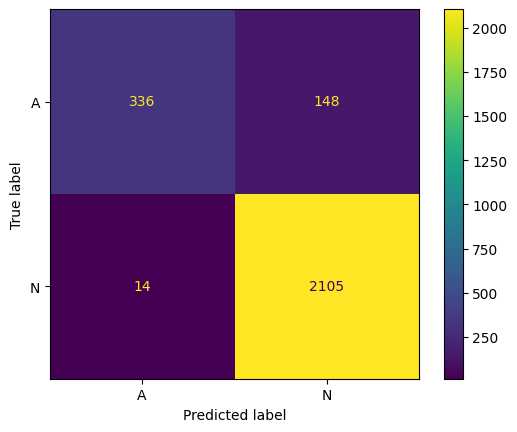

In [192]:
plot_confusionMatrix(test_GT, np.array(df.iloc[:-1].labels), exp.clf)

In [150]:
def A_to_N_ratio(self, time_window=20, fs=128):
    indices_before = int(time_window*fs)

    ratio = np.zeros(len(self.peaks))
    for i, peak_idx in enumerate(self.peaks):
        indices_in_window = np.where((peak_idx - indices_before <= self.peaks) & (self.peaks < peak_idx))[0]

        count_N = np.count_nonzero((self.labels[indices_in_window] ==  'N'))
        count_V = np.count_nonzero((self.labels[indices_in_window] ==  'V'))
        count_S = np.count_nonzero((self.labels[indices_in_window] ==  'S'))
        
        # Handle the case were count_N is 0
        if count_N == 0:
            count_N = 1

        ratio[i] = (count_V+count_S)/count_N

    return ratio

In [151]:
A_to_N_ratio(df.loc[0:0])

array([0.])

In [145]:
df

,peaks,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
0,83,N,1.031250,0.632812,-0.074814,-0.345831,0.880778,0.781693,0.695468,-0.694012,0.772990,3.111276,0.210938,-0.715613,1.103237,0.012297,0.062113,0.068949,0.690797,0.0
1,165,NaN,0.640625,0.250000,-0.074206,-0.091540,0.849451,0.730475,0.012791,-1.337709,0.468151,2.626051,0.179688,-2.350049,0.993750,0.009069,0.070542,0.046523,0.640625,NaN
2,247,NaN,0.640625,0.250000,0.007296,-0.030241,0.917613,0.852409,0.042105,-1.364003,0.507204,2.832734,0.187500,-0.954381,0.974546,0.010833,0.074184,0.058178,0.640625,NaN
3,330,NaN,0.562500,0.265625,0.064259,0.110945,0.824823,0.689915,-0.265204,-1.122555,0.396309,2.631315,0.187500,-2.598195,0.968880,0.008414,0.071950,0.039970,0.648438,NaN
4,394,NaN,0.679688,0.234375,-0.119052,-0.184392,0.574101,0.333425,0.047393,-1.105410,0.338187,1.944462,0.171875,-2.065566,0.966895,0.004433,0.043567,0.025463,0.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,229811,NaN,0.750000,0.414062,0.340026,0.391122,2.141126,4.632676,-0.029298,-1.510230,1.437881,6.124574,0.273438,-7.933877,0.945803,0.059238,0.142995,0.341581,0.695312,NaN
2599,229896,NaN,0.867188,0.468750,-0.317381,-0.352235,1.409751,2.005464,0.038765,-1.094432,1.056612,4.832670,0.195312,-0.425249,1.101270,0.027285,0.084708,0.170034,0.664062,NaN
2600,229984,NaN,0.359375,0.226562,0.227199,0.625316,0.846697,0.732826,-0.731233,-1.034103,0.284569,2.421949,0.203125,-2.051181,0.810459,0.008841,0.078877,0.037362,0.687500,NaN
2601,230050,NaN,0.804688,0.148438,-0.324889,-0.263610,1.015647,1.041652,-0.167290,-1.342010,0.734156,3.032510,0.257812,-2.149185,0.656656,0.017441,0.058804,0.120150,0.515625,NaN


In [72]:
exp.clf.predict(row0_zscore)

ValueError: X has 18 features, but RandomForestClassifier is expecting 11 features as input.

In [8]:
recording = ML_Test('S001_128.mat')
recording.get_intra_crop_features()
recording.get_inter_crop_features()
recording.get_patient_specific_features()
recording.construct_dataframe(write=False)

filtering signal S001_128.mat...


,peaks,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,...,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio,name
0,83,N,1.031250,0.632812,-0.074814,-0.345831,0.880778,0.781693,0.695468,-0.694012,...,3.111276,0.210938,-0.715613,1.103237,0.012297,0.062113,0.068949,0.690797,0.000000,1.0
1,165,N,0.640625,0.250000,-0.074206,-0.091540,0.849451,0.730475,0.012791,-1.337709,...,2.626051,0.179688,-2.350049,0.993750,0.009069,0.070542,0.046523,0.640625,0.000000,1.0
2,247,N,0.640625,0.250000,0.007296,-0.030241,0.917613,0.852409,0.042105,-1.364003,...,2.832734,0.187500,-0.954381,0.974546,0.010833,0.074184,0.058178,0.640625,0.000000,1.0
3,330,N,0.562500,0.265625,0.064259,0.110945,0.824823,0.689915,-0.265204,-1.122555,...,2.631315,0.187500,-2.598195,0.968880,0.008414,0.071950,0.039970,0.648438,0.000000,1.0
4,394,S,0.679688,0.234375,-0.119052,-0.184392,0.574101,0.333425,0.047393,-1.105410,...,1.944462,0.171875,-2.065566,0.966895,0.004433,0.043567,0.025463,0.500000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,229811,N,0.750000,0.414062,0.340026,0.391122,2.141126,4.632676,-0.029298,-1.510230,...,6.124574,0.273438,-7.933877,0.945803,0.059238,0.142995,0.341581,0.695312,0.037037,1.0
2599,229896,N,0.867188,0.468750,-0.317381,-0.352235,1.409751,2.005464,0.038765,-1.094432,...,4.832670,0.195312,-0.425249,1.101270,0.027285,0.084708,0.170034,0.664062,0.037037,1.0
2600,229984,N,0.359375,0.226562,0.227199,0.625316,0.846697,0.732826,-0.731233,-1.034103,...,2.421949,0.203125,-2.051181,0.810459,0.008841,0.078877,0.037362,0.687500,0.037037,1.0
2601,230050,S,0.804688,0.148438,-0.324889,-0.263610,1.015647,1.041652,-0.167290,-1.342010,...,3.032510,0.257812,-2.149185,0.656656,0.017441,0.058804,0.120150,0.515625,0.037037,1.0


In [7]:
#---------------------------------------------------
#               Get features dataframe
#---------------------------------------------------
def merge_csv_files(self, folder_path):
    # Get a list of all CSV files in the specified folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Initialize an empty list to store individual DataFrames
    dfs = []

    # Loop through each CSV file and append its DataFrame to the list
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)

    return merged_df